# Validation

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [4]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.0330837279367548
Training loss: 0.5605115163555023
Training loss: 0.4899622876761056


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

with torch.no_grad():
    logps = model(img)

In [6]:
ps = torch.exp(logps)
ps

tensor([[2.2996e-06, 2.8763e-07, 5.5814e-06, 1.0909e-06, 4.0892e-06, 1.0550e-01,
         6.2521e-06, 3.2236e-01, 6.3683e-03, 5.6576e-01]])

In [7]:
nps = ps.numpy()[0]
nps

array([2.2996344e-06, 2.8763074e-07, 5.5814035e-06, 1.0909203e-06,
       4.0892369e-06, 1.0549851e-01, 6.2521153e-06, 3.2235703e-01,
       6.3682911e-03, 5.6575662e-01], dtype=float32)

<BarContainer object of 10 artists>

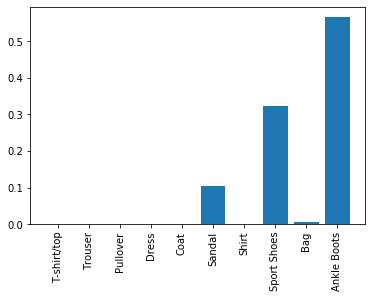

In [8]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boots']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

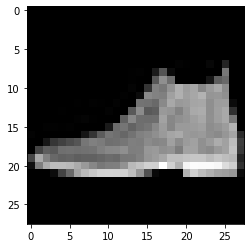

In [9]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

In [10]:
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        print(output)
        cnt+=1
        
        if cnt > 0:
          break

tensor([[2.2996e-06, 2.8763e-07, 5.5814e-06, 1.0909e-06, 4.0892e-06, 1.0550e-01,
         6.2521e-06, 3.2236e-01, 6.3683e-03, 5.6576e-01],
        [1.2639e-03, 4.2291e-05, 8.9812e-01, 1.9489e-04, 1.8098e-02, 9.3093e-06,
         8.1457e-02, 5.5758e-09, 8.1088e-04, 3.7371e-07],
        [3.3151e-05, 9.9974e-01, 3.0536e-05, 1.1877e-04, 7.1795e-05, 2.6324e-08,
         2.3303e-07, 6.9726e-07, 8.2682e-09, 1.2902e-08],
        [8.5175e-06, 9.9945e-01, 3.7075e-05, 4.5752e-04, 4.8244e-05, 1.9500e-07,
         1.7794e-07, 3.0953e-06, 1.6362e-08, 8.9802e-08],
        [1.4156e-01, 4.7915e-04, 1.4620e-01, 1.4308e-02, 1.0319e-02, 2.2091e-04,
         6.7772e-01, 1.1854e-06, 9.1712e-03, 1.0658e-05],
        [4.1099e-03, 9.8315e-01, 9.2229e-04, 2.8325e-03, 8.8148e-03, 6.4410e-07,
         1.6051e-04, 5.1487e-06, 2.2893e-06, 3.3823e-07],
        [2.5838e-02, 9.7955e-04, 5.6154e-02, 1.4196e-03, 6.8864e-01, 1.2493e-04,
         2.2331e-01, 1.1381e-06, 3.5328e-03, 1.4889e-06],
        [7.5150e-03, 2.2281

         1.8327e-03, 2.1848e-02, 1.1607e-02, 5.1866e-03]])


In [11]:
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)


In [12]:
pred, labels

(tensor([3, 0, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]),
 tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]))

In [13]:
pred == labels

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True])

In [14]:
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {num_correct * 100 / total}% ')

Accuracy of the model on the 10000 test images: 82.13% 
